In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv',encoding ='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [2]:
spam_df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [3]:
spam_df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
#converting the value of ham and spam into 1 or 0
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
spam_df['v1'] = encoder.fit_transform(spam_df['v1'])

In [5]:
#validation things worked so far
spam_df.head()
spam_df.isnull().sum()

v1    0
v2    0
dtype: int64

In [6]:
#check the duplicate values
spam_df.duplicated().sum()

403

In [7]:
#removing the duplicate value
spam_df = spam_df.drop_duplicates(keep = 'first')
spam_df.duplicated().sum()

0

In [8]:
spam_df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
spam_df['num_character'] = spam_df['v2'].apply(len)
!pip  install nltk
import nltk
nltk.download('punkt')
spam_df['num_words'] = spam_df['v2'].apply(lambda x:len(nltk.word_tokenize(x)))
spam_df['num_sentence'] = spam_df['v2'].apply(lambda x : len(nltk.sent_tokenize(x)))
spam_df.head()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,v1,v2,num_character,num_words,num_sentence
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


# DATA PROCESSING

In [10]:
#here we are going to convert the text data into suitable format
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
import string

def transformTexts(text):
    text = text.lower()
    #tokenizing the text based on the words in the text
    text = nltk.word_tokenize(text)
    #including all those characters which are alphabet or number
    y = []
    for i in text:
        if i.isalnum:
            y.append(i)
            
    #storing the value of y into the vaiable text
    text = y[:]
    y.clear()
    
    #Removing the unnecessary words such as 'how are you ' or something which is not importent 
    #down here the stopwords.words('english') is nothing but all the lame set of words as described above
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    #the last step is nothing but steming in the steming we basically convert every verb form into the simple form such as
    #if we have dancing or danced we will convert them into dance and so on for this need to import something  hehehehe
    
    text = y[:]
    y.clear()
    ps = PorterStemmer()
    
    for i in text:
        y.append(ps.stem(i))
    
    text = y[:]
    y.clear()
    
    return " ".join(text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
transformTexts('Hi Shehriar how are you? Did you eat my salad?And if you are dancing tell me I danced very well last time')

'hi shehriar eat salad danc tell danc well last time'

Now I am going to run this function for whole of the text we have in our dataset and then create a new column to add 
transformed text there

In [12]:
spam_df['transformed'] = spam_df['v2'].apply(transformTexts)

In [13]:
spam_df.head()

,v1,v2,num_character,num_words,num_sentence,transformed
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2,go jurong point crazy.. avail bugi n great wor...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar ... joke wif u oni ...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor ... u c alreadi say ...
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah n't think goe usf live around though


now we are going to figure the importent or some of the most used words from the spam text

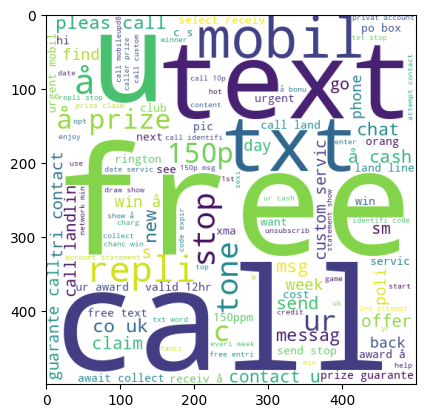

In [14]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wc = WordCloud(width = 500,height = 500,min_font_size = 10,background_color = 'white')
spam_wc = wc.generate(spam_df[spam_df['v1'] == 1]['transformed'].str.cat(sep = " "))
plt.imshow(spam_wc)

now our next step is to extract all the 30 words which has more frequency in both ham and spam

In [15]:
spam_corpus = []
for msg in spam_df[spam_df['v1']==1]['transformed'].tolist():
    for word in msg.split():
        spam_corpus.append(word)
        
#same for the ham messages 
ham_corpus = []
for msg in spam_df[spam_df['v1']==0]['transformed'].tolist():
    for word in msg:
        ham_corpus.append(word)

In [16]:
spam_corpus_df = pd.DataFrame(spam_corpus)
spam_corpus_df.head()

,0
0,free
1,entri
2,2
3,wkli
4,comp


In [17]:
# # !pip install seaborn
# from collections import Counter
# import seaborn as sns
# sns.barplot(pd.DataFrame(Counter(ham_corpus).most_common(30))[0],pd.DataFrame(Counter(ham_corpus).most_common(30))[1])

# MODEL SELECTION

in this we will select the most appropiate model for our data set

In [18]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)
gb = GaussianNB()
mb = MultinomialNB()
bb = BernoulliNB()

#seperating X and y
X = tfidf.fit_transform(spam_df['transformed']).toarray()
y = spam_df['v1']
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)
X_train.shape

(4135, 3000)

# Checking the three model for better result 

In [20]:
# gb.fit(X_train,y_train)
# gb.score(X_test,y_test)
mb.fit(X_train, y_train)
mb.score(X_train, y_train)
# bb.fit(X_train,y_train)
# bb.score(X_test,y_test)

0.9845223700120919

so experimenting on the model I came to realize that the mb is fittest one among the three I do not want try more models
becuase I am very lazy hehehehehe

In [21]:
import pickle
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
pickle.dump(mb, open('model.pkl', 'wb'))